## PyCitySchools Assignment
*Eric Nordstrom  
UT Data Analysis & Visualization Boot Camp*

### Notes:
* This notebook comes from a starter notebook provided for this project by the boot camp. A small amount of the content was written by boot camp staff.
* A written analysis is included at the bottom of this notebook.

In [1]:
# Dependencies and Setup
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# File to Load (Remember to Change These)
school_data_to_load = "schools_complete.csv"
student_data_to_load = "students_complete.csv"

# Read School and Student Data File and store into Pandas Data Frames
school_data = pd.read_csv(school_data_to_load)
student_data = pd.read_csv(student_data_to_load)

# Combine the data into a single dataset
school_data_complete = pd.merge(student_data, school_data, how="left", on=["school_name", "school_name"])

# View data
school_data_complete.head()

,Student ID,student_name,gender,grade,school_name,reading_score,math_score,School ID,type,size,budget
0,0,Paul Bradley,M,9th,Huang High School,66,79,0,District,2917,1910635
1,1,Victor Smith,M,12th,Huang High School,94,61,0,District,2917,1910635
2,2,Kevin Rodriguez,M,12th,Huang High School,90,60,0,District,2917,1910635
3,3,Dr. Richard Scott,M,12th,Huang High School,67,58,0,District,2917,1910635
4,4,Bonnie Ray,F,9th,Huang High School,97,84,0,District,2917,1910635


## District Summary

* Calculate the total number of schools

* Calculate the total number of students

* Calculate the total budget

* Calculate the average math score 

* Calculate the average reading score

* Calculate the overall passing rate (overall average score), i.e. (avg. math score + avg. reading score)/2

* Calculate the percentage of students with a passing math score (70 or greater)

* Calculate the percentage of students with a passing reading score (70 or greater)

* Create a dataframe to hold the above results

* Optional: give the displayed data cleaner formatting

In [2]:
# District summary calculations

total_schools = len(school_data)
total_students = len(school_data_complete)
total_budget = school_data['budget'].sum()

average_math_score = school_data_complete['math_score'].mean()
average_reading_score = school_data_complete['reading_score'].mean()
pct_overall_passing_rate = (average_math_score + average_reading_score) / 2

num_passing_math = (school_data_complete['math_score'] >= 70).sum()
pct_passing_math = 100 * num_passing_math / total_students

num_passing_reading = (school_data_complete['reading_score'] >= 70).sum()
pct_passing_reading = 100 * num_passing_reading / total_students

column_names = [
    'total_schools',
    'total_students',
    'total_budget',
    'average_math_score',
    'average_reading_score',
    'pct_passing_math',
    'pct_passing_reading',
    'pct_overall_passing_rate'
]

df = pd.DataFrame(
    [[eval(name) for name in column_names]],
    columns=column_names
)

df

,total_schools,total_students,total_budget,average_math_score,average_reading_score,pct_passing_math,pct_passing_reading,pct_overall_passing_rate
0,15,39170,24649428,78.985371,81.87784,74.980853,85.805463,80.431606


In [3]:
# District summary formatting

df\
.assign(
    total_students = [f'{df.total_students[0]:,}'],
    total_budget = [f'${df.total_budget[0]:,.2f}'],
    **{
        name: [f'{df[name][0]:.2f} %']
        for name in column_names
        if name.split('_')[0] in {
            'average',
            'pct'
        }
    }
)\
.rename(columns={
    name: ' '.join(name.split('_'))
    .replace('pct', '%')
    .title()
    for name in column_names
})

,Total Schools,Total Students,Total Budget,Average Math Score,Average Reading Score,% Passing Math,% Passing Reading,% Overall Passing Rate
0,15,"39,170","$24,649,428.00",78.99 %,81.88 %,74.98 %,85.81 %,80.43 %


## School Summary

* Create an overview table that summarizes key metrics about each school, including:
  * School Name
  * School Type
  * Total Students
  * Total School Budget
  * Per Student Budget
  * Average Math Score
  * Average Reading Score
  * % Passing Math
  * % Passing Reading
  * Overall Passing Rate (Average of the above two)
  
* Create a dataframe to hold the above results

In [4]:
# group by school
by_school = school_data_complete.groupby('school_name')

# column extractions and calculations
student_counts = by_school['Student ID'].nunique()
type_and_total_budget = by_school[['type', 'budget']].first()
per_student_budget = type_and_total_budget['budget'] / student_counts
scores = by_school[['math_score', 'reading_score']]
average_scores = scores.mean().rename(columns={
    'math_score': 'average_math_score',
    'reading_score': 'average_reading_score'
})
passing_counts = scores.apply(lambda scores_by_school: (scores_by_school >= 70).sum())
passing_pcts = passing_counts[[]].assign(
    pct_passing_math=passing_counts['math_score'] / student_counts,
    pct_passing_reading=passing_counts['reading_score'] / student_counts
) * 100
overall_passing_rate = passing_pcts.mean(axis=1)

# construct the school summary data frame
school_summary = type_and_total_budget\
.rename(columns={
    'type': 'school_type',
    'budget': 'total_budget'
})\
.assign(
    total_students=student_counts,
    per_student_budget=per_student_budget,
    overall_passing_rate=overall_passing_rate
)\
.merge(average_scores, left_index=True, right_index=True)\
.merge(passing_pcts, left_index=True, right_index=True)


# for formatting

column_order = [0, 2, 1, 3, 5, 6, 7, 8, 4]
format_as_number = [
    'total_students'
]
format_as_money = [
    'total_budget',
    'per_student_budget'
]
format_as_pct = [
    'average_math_score',
    'average_reading_score',
    'pct_passing_math',
    'pct_passing_reading',
    'overall_passing_rate'
]
number_format = '{:,}'
money_format = '${:,.0f}'
pct_format = '{:.2f}%'

def format_column_name(column_name):
    return ' '.join(column_name.split('_')).replace('pct', '%').title()

def formatted_school_summary(summary_df, column_order=column_order):
    '''format a data frame with appropriate columns for a school-by-school summary'''
    
    original_columns = school_summary.columns
    
    return summary_df[[original_columns[index] for index in column_order if original_columns[index] in summary_df.columns]]\
    .assign(
        **{col_name: summary_df[col_name].apply(lambda x: number_format.format(x)) for col_name in format_as_number if col_name in summary_df.columns},
        **{col_name: summary_df[col_name].apply(lambda x: money_format.format(x)) for col_name in format_as_money if col_name in summary_df.columns},
        **{col_name: summary_df[col_name].apply(lambda x: pct_format.format(x)) for col_name in format_as_pct if col_name in summary_df.columns}
    )\
    .rename(columns={name: format_column_name(name) for name in original_columns})\
    .rename_axis(format_column_name(summary_df.index.name))

    
# present school summary
formatted_school_summary(school_summary)

,School Type,Total Students,Total Budget,Per Student Budget,Average Math Score,Average Reading Score,% Passing Math,% Passing Reading,Overall Passing Rate
School Name,,,,,,,,,
Bailey High School,District,"4,976","$3,124,928",$628,77.05%,81.03%,66.68%,81.93%,74.31%
Cabrera High School,Charter,"1,858","$1,081,356",$582,83.06%,83.98%,94.13%,97.04%,95.59%
Figueroa High School,District,"2,949","$1,884,411",$639,76.71%,81.16%,65.99%,80.74%,73.36%
Ford High School,District,"2,739","$1,763,916",$644,77.10%,80.75%,68.31%,79.30%,73.80%
Griffin High School,Charter,"1,468","$917,500",$625,83.35%,83.82%,93.39%,97.14%,95.27%
Hernandez High School,District,"4,635","$3,022,020",$652,77.29%,80.93%,66.75%,80.86%,73.81%
Holden High School,Charter,427,"$248,087",$581,83.80%,83.81%,92.51%,96.25%,94.38%
Huang High School,District,"2,917","$1,910,635",$655,76.63%,81.18%,65.68%,81.32%,73.50%
Johnson High School,District,"4,761","$3,094,650",$650,77.07%,80.97%,66.06%,81.22%,73.64%


## Top Performing Schools (By Passing Rate)

* Sort and display the top five schools in overall passing rate

In [5]:
# top performing schools by overall passing rate
formatted_school_summary(school_summary.sort_values('overall_passing_rate', ascending=False).head(5))

,School Type,Total Students,Total Budget,Per Student Budget,Average Math Score,Average Reading Score,% Passing Math,% Passing Reading,Overall Passing Rate
School Name,,,,,,,,,
Cabrera High School,Charter,"1,858","$1,081,356",$582,83.06%,83.98%,94.13%,97.04%,95.59%
Thomas High School,Charter,"1,635","$1,043,130",$638,83.42%,83.85%,93.27%,97.31%,95.29%
Pena High School,Charter,962,"$585,858",$609,83.84%,84.04%,94.59%,95.95%,95.27%
Griffin High School,Charter,"1,468","$917,500",$625,83.35%,83.82%,93.39%,97.14%,95.27%
Wilson High School,Charter,"2,283","$1,319,574",$578,83.27%,83.99%,93.87%,96.54%,95.20%


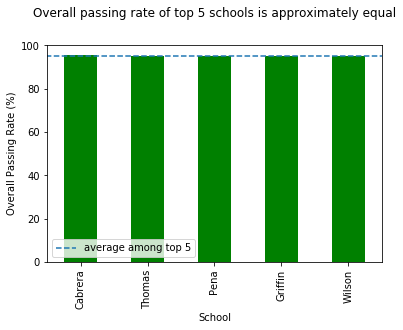

In [6]:
# observe trend
best_performing = _['Overall Passing Rate'].apply(lambda string: string[:-1]).astype(float)
plt.plot(
    [-1, 5],
    [best_performing.mean()] * 2,
    '--',
    label='average among top 5'
)
plt.legend(title='')  # For some reason, "None" appears when the empty legend title isn't specified.
best_performing.plot.bar(color='green')
plt.xticks(
    range(5),
    (' '.join(name.split()[:-2]) for name in best_performing.index),
    rotation=90
)
plt.xlabel('School')
plt.ylabel('Overall Passing Rate (%)')
plt.title('Overall passing rate of top 5 schools is approximately equal', y=1.1)
plt.show()

## Bottom Performing Schools (By Passing Rate)

* Sort and display the five worst-performing schools

In [7]:
# worst performing schools by overall passing rate
formatted_school_summary(school_summary.sort_values('overall_passing_rate').head(5))

,School Type,Total Students,Total Budget,Per Student Budget,Average Math Score,Average Reading Score,% Passing Math,% Passing Reading,Overall Passing Rate
School Name,,,,,,,,,
Rodriguez High School,District,"3,999","$2,547,363",$637,76.84%,80.74%,66.37%,80.22%,73.29%
Figueroa High School,District,"2,949","$1,884,411",$639,76.71%,81.16%,65.99%,80.74%,73.36%
Huang High School,District,"2,917","$1,910,635",$655,76.63%,81.18%,65.68%,81.32%,73.50%
Johnson High School,District,"4,761","$3,094,650",$650,77.07%,80.97%,66.06%,81.22%,73.64%
Ford High School,District,"2,739","$1,763,916",$644,77.10%,80.75%,68.31%,79.30%,73.80%


## Math Scores by Grade

* Create a table that lists the average Reading Score for students of each grade level (9th, 10th, 11th, 12th) at each school.

  * Create a pandas series for each grade. Hint: use a conditional statement.
  
  * Group each series by school
  
  * Combine the series into a dataframe
  
  * Optional: give the displayed data cleaner formatting

In [8]:
# math scores by grade
by_school_and_grade = school_data_complete.groupby(['school_name', 'grade'])
math_scores = by_school_and_grade['math_score'].mean().unstack()
math_scores.columns.name = math_scores.index.name = None
math_scores = math_scores[['9th', '10th', '11th', '12th']]
math_scores

,9th,10th,11th,12th
Bailey High School,77.083676,76.996772,77.515588,76.492218
Cabrera High School,83.094697,83.154506,82.765560,83.277487
Figueroa High School,76.403037,76.539974,76.884344,77.151369
Ford High School,77.361345,77.672316,76.918058,76.179963
Griffin High School,82.044010,84.229064,83.842105,83.356164
Hernandez High School,77.438495,77.337408,77.136029,77.186567
Holden High School,83.787402,83.429825,85.000000,82.855422
Huang High School,77.027251,75.908735,76.446602,77.225641
Johnson High School,77.187857,76.691117,77.491653,76.863248
Pena High School,83.625455,83.372000,84.328125,84.121547


## Reading Score by Grade 

* Perform the same operations as above for reading scores

In [9]:
# reading scores by grade
reading_scores = by_school_and_grade['reading_score'].mean().unstack()
reading_scores.columns.name = reading_scores.index.name = None
reading_scores = reading_scores[['9th', '10th', '11th', '12th']]
reading_scores

,9th,10th,11th,12th
Bailey High School,81.303155,80.907183,80.945643,80.912451
Cabrera High School,83.676136,84.253219,83.788382,84.287958
Figueroa High School,81.198598,81.408912,80.640339,81.384863
Ford High School,80.632653,81.262712,80.403642,80.662338
Griffin High School,83.369193,83.706897,84.288089,84.013699
Hernandez High School,80.866860,80.660147,81.396140,80.857143
Holden High School,83.677165,83.324561,83.815534,84.698795
Huang High School,81.290284,81.512386,81.417476,80.305983
Johnson High School,81.260714,80.773431,80.616027,81.227564
Pena High School,83.807273,83.612000,84.335938,84.591160


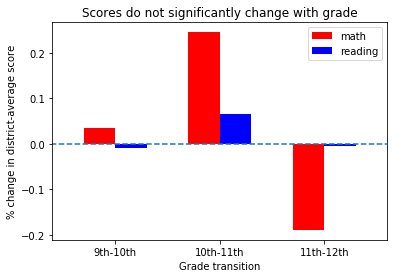

In [10]:
# observe trend

width = .3

plt.bar(
    np.arange(-width/2, 3 - width/2),
    math_scores.mean().pct_change().iloc[1:] * 100,
    width,
    color='red',
    label='math'
)
plt.bar(
    np.arange(width/2, 3 + width/2),
    reading_scores.mean().pct_change().iloc[1:] * 100,
    width,
    color='blue',
    label='reading'
)
plt.plot((-1, 3), (0, 0), '--')
plt.legend()
plt.xlim(-width * 2, 2 + width * 2)
plt.xticks(range(3), ['9th-10th', '10th-11th', '11th-12th'], rotation=0)
plt.xlabel('Grade transition')
plt.ylabel('% change in district-average score')
plt.title('Scores do not significantly change with grade')
plt.show()

## Scores by School Spending

* Create a table that breaks down school performances based on average Spending Ranges (Per Student). Use 4 reasonable bins to group school spending. Include in the table each of the following:
  * Average Math Score
  * Average Reading Score
  * % Passing Math
  * % Passing Reading
  * Overall Passing Rate (Average of the above two)

In [11]:
# show that all per-student spending amounts are integers
school_summary['per_student_budget'].value_counts().sort_index()

578.0    1
581.0    1
582.0    1
583.0    1
600.0    1
609.0    1
625.0    1
628.0    1
637.0    1
638.0    1
639.0    1
644.0    1
650.0    1
652.0    1
655.0    1
Name: per_student_budget, dtype: int64

In [12]:
# group by spending and show which schools are in which category

summary_with_school_names = school_summary.reset_index()  # make school names into their own column to see which schools are in which bin

by_spending = summary_with_school_names.groupby(
    pd.cut(np.log(summary_with_school_names['per_student_budget']), 4)\
    .apply(lambda intvl: f'${np.ceil(np.exp(intvl.left)):.0f}-{np.floor(np.exp(intvl.right)):.0f}')  # okay to leave out non-integer possibilities because all amounts are integers
)

by_spending['school_name'].apply(lambda series: ', '.join(' '.join(name.split()[:-2]) for name in series))

per_student_budget
$578-596                      Cabrera, Holden, Wilson, Wright
$597-615                                        Pena, Shelton
$616-634                                      Bailey, Griffin
$635-655    Figueroa, Ford, Hernandez, Huang, Johnson, Rod...
Name: school_name, dtype: object

***At first thought, it seems we should look at the average statistics among students. However, since we want to see the effect of spending, it might make sense to consider each school as a single data point, representing the different conditions among schools.***

In [13]:
# display score data by spending

formatted_school_summary(by_spending[[
    'average_math_score',
    'average_reading_score',
    'pct_passing_math',
    'pct_passing_reading',
    'overall_passing_rate'
]].mean())

,Average Math Score,Average Reading Score,% Passing Math,% Passing Reading,Overall Passing Rate
Per Student Budget,,,,,
$578-596,83.46%,83.93%,93.46%,96.61%,95.04%
$597-615,83.60%,83.89%,94.23%,95.90%,95.07%
$616-634,80.20%,82.43%,80.04%,89.54%,84.79%
$635-655,77.87%,81.37%,70.35%,83.00%,76.67%


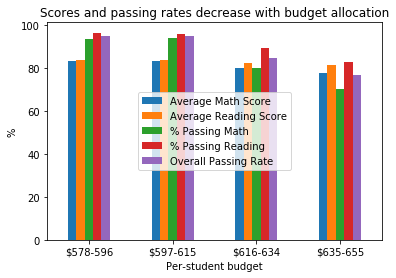

In [14]:
# observe trend

scores_by_budget = _.assign(**{col: _[col].apply(lambda s: s[:-1]).astype(float) for col in _.columns})
scores_by_budget.plot.bar()
plt.xticks(rotation=0)
plt.xlabel('Per-student budget')
plt.ylabel('%')
plt.legend(loc='center')
plt.title('Scores and passing rates decrease with budget allocation')
plt.show()

*This might be because the effect is actually the reverse: schools score lower if they have students of less affluent communities, therefore requiring government assistance.*

## Scores by School Size

* Perform the same operations as above, based on school size.

In [15]:
# group by school size and show which schools are in which category
bin_names = ['Small', 'Medium', 'Large']
by_size = summary_with_school_names.groupby(pd.cut(np.log(summary_with_school_names['total_students']), 3, labels=bin_names))
by_size['school_name'].apply(lambda series: ', '.join(' '.join(name.split()[:-2]) for name in series))

total_students
Small                                          Holden, Pena
Medium            Cabrera, Griffin, Shelton, Thomas, Wright
Large     Bailey, Figueroa, Ford, Hernandez, Huang, John...
Name: school_name, dtype: object

In [16]:
# display score data by size category

formatted_school_summary(by_size[[
    'average_math_score',
    'average_reading_score',
    'pct_passing_math',
    'pct_passing_reading',
    'overall_passing_rate'
]].mean())\
.rename_axis('School Size')

,Average Math Score,Average Reading Score,% Passing Math,% Passing Reading,Overall Passing Rate
School Size,,,,,
Small,83.82%,83.93%,93.55%,96.10%,94.82%
Medium,83.37%,83.86%,93.60%,96.79%,95.20%
Large,77.75%,81.34%,69.96%,82.77%,76.36%


## Scores by School Type

* Perform the same operations as above, based on school type.

In [17]:
# scores by school type

by_type = school_summary.groupby('school_type')
by_type.first()

formatted_school_summary(by_type[[
    'average_math_score',
    'average_reading_score',
    'pct_passing_math',
    'pct_passing_reading',
    'overall_passing_rate'
]].mean())

,Average Math Score,Average Reading Score,% Passing Math,% Passing Reading,Overall Passing Rate
School Type,,,,,
Charter,83.47%,83.90%,93.62%,96.59%,95.10%
District,76.96%,80.97%,66.55%,80.80%,73.67%


## Analysis

The figures included in this notebook indicate the following trends:
* From the school-by-school summary, it was found that the overall passing rates of the top 5 schools are approximately equal in the range of 95-96%; an outlier is not present in this subsample. If the #1 school were significantly better performing than others, it could be used as a model school.
* From the score decompositions by grade level, it was found that neither math nor reading scores change significantly from grade to grade. It might be useful to know more about how the scores are calculated; if they are in fact percentiles, this could be the reason for the negligible changes since the scores are normalized each year.
* From the analysis of performance by school spending amount, it was found that all performance indicators (scores and passing rates) tend to decrease as the budget increases. This does not mean increasing a school's budget will cause its performance to decrease, but rather could mean that the direction of causation is reversed and schools score lower if they have students of less affluent communities. Poorer communities may have larger per-student budgets due to government assistance.